In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle 

f = open('drive/MyDrive/EnergyLog.pkl','rb')
all_data = pickle.load(f)
f.close()

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns
import datetime
import pickle

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Input, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed


In [ ]:
Energylog = all_data
#mean voltage aldım uzunluğa burdan bakıyorum
MeanVoltage = Energylog[:,5]
MeanVoltage = MeanVoltage.reshape(-1,1)
#time sample
timeSample = Energylog[:,1]
timeSampleNumber = np.zeros((len(MeanVoltage),1))
print(MeanVoltage.shape)

(3479120, 1)


In [ ]:
## date'i timestampe çevirdik elimizde  number olmuş oldu
for i in range(len(MeanVoltage)):
    try:
        datem = datetime.datetime.strptime(timeSample[i], "%Y-%m-%d %H:%M:%S")
        date = datetime.datetime.timestamp(datem)
        timeSampleNumber[i] = date
    except:
        pass
# yeni bir matris oluşturdum sensor idsini kaldırdım ortadan time stamp olarak en başa ekledim.
NewEnergylog = Energylog[:,2:7]
timeSampleNumber= timeSampleNumber.reshape(-1,1)
NewEnergylog= np.hstack((timeSampleNumber,NewEnergylog))

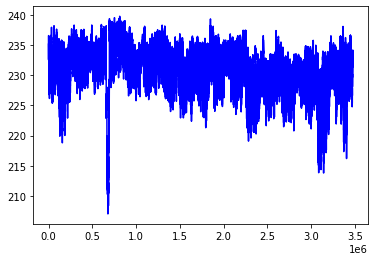

In [ ]:
dataset = pd.DataFrame({'timeStamps': NewEnergylog[:,0],'MeanVoltage': NewEnergylog[:,4]})

# Train test diye ayıracağız. Mean oltage için SAATLİK (direkt timestamp değil ortalamalı grafiktenbakıyorum)
# incelemelrde anomaliyi 700 öncesinde görüyoruz 2100 sonrasında var gibi biraz.
time = np.arange(0,len(MeanVoltage))
plt.plot(time, MeanVoltage, 'b', label='MeanVoltage')
plt.show()


# bu grafikte de direkt timestamp olarak bakıldı 8*10^5 ve 3*10^6 arası en normal olduğu yerler
# 3 milyon sonrası veya 0-8*10^5 arası test set olabilir. ilk tercihim 0-800k arası çünkü esas anomali orda


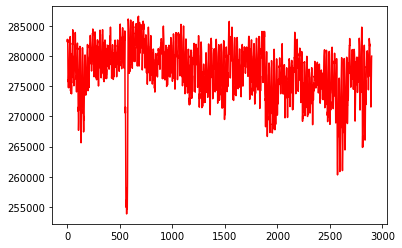

In [ ]:
windowSize = 1200
# 1200 saatlik 
# 28800 günlük 
tempVector = np.zeros((windowSize,1))
tempVector = MeanVoltage[(1* windowSize):(1+1)*windowSize, 0]

k = int(len(MeanVoltage)/windowSize)
meanValues = np.zeros((k,1))

for i in range(k):
    tempVector = MeanVoltage[(i*windowSize):(i+1)*windowSize,0]
    meanValues[i] = sum(tempVector)

"""  """
# buraya tırnaklar
time = np.arange(0,k)
plt.plot(time, meanValues, 'r', label='MeanValues')
plt.show()


In [ ]:
print(NewEnergylog.shape)
print(Energylog.shape)
print(NewEnergylog[0:3,:])


(3479120, 6)
(3479120, 7)
[[1601510400.0 705.005 5.388 178.50900000000001 235.165 2115438.4]
 [1601510403.0 728.811 16.023 170.84400000000002 234.685 2115438.9]
 [1601510406.0 716.5989999999999 28.81 166.299 235.11700000000002
  2115439.6]]


In [ ]:
#Train test diye ayıracağız YALNIZ direkt 800,000 yazınca olmaz çünkü timestampte farklı bir değer var. o yüzden bir değişken tanımlıyorum
VariableSplit2 = NewEnergylog[800000,0]
VariableSplit = NewEnergylog[500000,0]

# 300,000 test setimiz oldu 
VariableSplit3 = NewEnergylog[2600000,0]
#2.5'ten sonrası 1 milyon da training set olsun 

In [ ]:
# aralık aldığımız için variable splite gerek kalmadı 
a = 500000
b = 800000

#housing.loc[1:7,['population', 'households']]
test  = dataset.loc[a:b,['timeStamps', 'MeanVoltage']]
train = dataset.loc[dataset['timeStamps'] > VariableSplit3]

In [ ]:

# normalize etmemiz lazım
testMeanVoltage = (np.array(test['MeanVoltage'])).reshape(-1,1)
testMeanVoltage = testMeanVoltage / max(testMeanVoltage)
trainMeanVoltage = (np.array(train['MeanVoltage'])).reshape(-1,1)
trainMeanVoltage = trainMeanVoltage / max(trainMeanVoltage)

print(test.shape)
print(test.head())
print(train.shape)
print(train.head())

(300001, 2)
         timeStamps MeanVoltage
500000  1.60302e+09     233.053
500001  1.60302e+09     233.053
500002  1.60302e+09     233.065
500003  1.60302e+09     232.969
500004  1.60302e+09     232.897
(879119, 2)
          timeStamps MeanVoltage
2600001  1.60948e+09     236.258
2600002  1.60948e+09     236.149
2600003  1.60948e+09     236.378
2600004  1.60948e+09     236.222
2600005  1.60948e+09     236.198


In [ ]:

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
#In this example, the n_features is 2. We will make timesteps = 3.
#With this, the resultant n_samples is 5 (as the input data has 9 rows).


#alttaki fonksiyonda problem yaşadığımız için panda dataframe olarak vermemiz lazım o yüzden testMeanVolt ile trainMeanVolt
#pandaya dönüşütürüyoruz geri

testTimeStamps =(np.array(test['timeStamps'])).reshape(-1,1)
trainTimeStamps =(np.array(train['timeStamps'])).reshape(-1,1)
""" """
TrainSet = pd.DataFrame({'timeStamps': trainTimeStamps[:,0],'MeanVoltage': trainMeanVoltage[:,0]})
TestSet  = pd.DataFrame({'timeStamps':  testTimeStamps[:,0],'MeanVoltage': testMeanVoltage[:,0]})
##### dönüştürdük iloc için####

In [ ]:

seq_size = 60  # Number of time steps to look back
# Larger sequences (look further back) may improve forecasting.
def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x) - seq_size):
        # print(i)
        x_values.append(x.iloc[i:(i + seq_size)].values)
        y_values.append(y.iloc[i + seq_size])

    return np.array(x_values), np.array(y_values)


trainX, trainY = to_sequences(TrainSet[['MeanVoltage']], TrainSet['MeanVoltage'], seq_size)
testX, testY = to_sequences(TestSet[['MeanVoltage']], TestSet['MeanVoltage'], seq_size)
##################################################################

In [ ]:
print(trainX.shape)
print(trainY.shape)


(879059, 60, 1)
(879059,)


In [ ]:
# bir hata alıyorduk failed to convert numpy array to a tensor diye o yüzden 
trainX = np.asarray(trainX).astype('float32')
trainY = np.asarray(trainY).astype('float32')

In [ ]:
## Burdan sonrasında kaydettiğimiz modeli çağırıp kullanalım 2 epoch ile train  ettiğimiz 

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(trainX.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 60, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [ ]:
# early stop kullanmıyoruz şu anda 
#from keras.callbacks import EarlyStopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

Epoch 1/2
19230/19230 [==============================] - 3090s 161ms/step - loss: 0.0081 - val_loss: 8.9910e-04
Epoch 2/2
19230/19230 [==============================] - 3409s 177ms/step - loss: 0.0017 - val_loss: 7.1341e-04


INFO:tensorflow:Assets written to: drive/MyDrive/lstmAutoEncoder/assets


INFO:tensorflow:Assets written to: drive/MyDrive/lstmAutoEncoder/assets


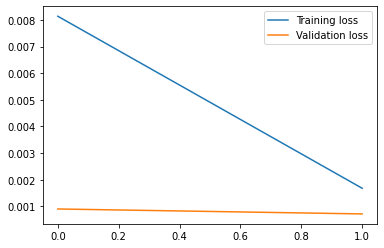

In [ ]:
history = model.fit(trainX, trainY, epochs=2, batch_size=32, validation_split=0.3, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

model.save('drive/MyDrive/lstmAutoEncoder') 



In [ ]:
from tensorflow import keras
lstmAutoEncoder = keras.models.load_model("drive/MyDrive/lstmAutoEncoder")

(array([3.70186e+05, 3.29629e+05, 1.10885e+05, 3.89280e+04, 1.58000e+04,
        6.76300e+03, 3.20200e+03, 1.58500e+03, 8.24000e+02, 5.11000e+02,
        2.89000e+02, 1.63000e+02, 1.02000e+02, 5.70000e+01, 4.20000e+01,
        4.20000e+01, 1.70000e+01, 1.30000e+01, 1.00000e+00, 2.00000e+00,
        5.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([0.00023843, 0.00081224, 0.00138604, 0.00195984, 0.00253364,
        0.00310745, 0.00368125, 0.00425505, 0.00482885, 0.00540266,
        0.00597646, 0.00655026, 0.00712406, 0.00769787, 0.00827167,
        0.00884547, 0.00941927, 0.00999308, 0.01056688, 0.01114068,
        0.01171448, 0.01228829, 0.01286209, 0.01343589, 0.01400969,
        0.0145835 , 0.0151573 , 0.0157311 , 0.0163049 , 0.01687871,
        0.01745251], dtype=float32),
 <a list of 30 Patch objects>)

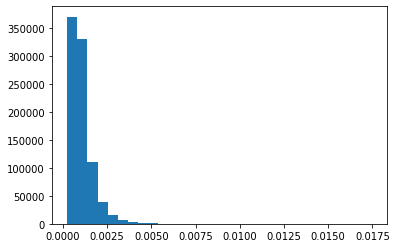

In [ ]:
 trainPredictSavedModel= lstmAutoEncoder.predict(trainX, verbose=0)
 trainMAESaved = np.mean(np.abs(trainPredictSavedModel - trainX), axis=1)
plt.hist(trainMAESaved, bins=30)

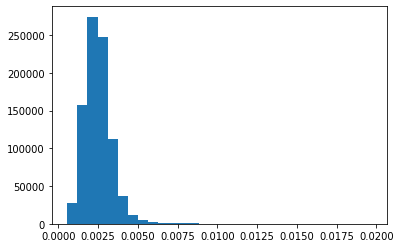

In [ ]:
#########Bu saved model değil ########
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly.
#Let us look at MAE in training prediction

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
#max_trainMAE = 0.3 

(array([9.02550e+04, 1.89901e+05, 1.71590e+04, 1.52400e+03, 5.80000e+02,
        3.33000e+02, 6.00000e+01, 2.00000e+01, 1.60000e+01, 1.60000e+01,
        8.00000e+00, 6.00000e+00, 7.00000e+00, 7.00000e+00, 6.00000e+00,
        1.20000e+01, 5.00000e+00, 1.00000e+00, 3.00000e+00, 2.00000e+00,
        2.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00, 3.00000e+00,
        3.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00, 3.00000e+00]),
 array([0.00052288, 0.00213071, 0.00373855, 0.00534639, 0.00695423,
        0.00856207, 0.01016991, 0.01177775, 0.01338559, 0.01499343,
        0.01660126, 0.0182091 , 0.01981694, 0.02142478, 0.02303262,
        0.02464046, 0.0262483 , 0.02785614, 0.02946397, 0.03107181,
        0.03267965, 0.03428749, 0.03589533, 0.03750317, 0.03911101,
        0.04071885, 0.04232669, 0.04393452, 0.04554236, 0.0471502 ,
        0.04875804], dtype=float32),
 <a list of 30 Patch objects>)

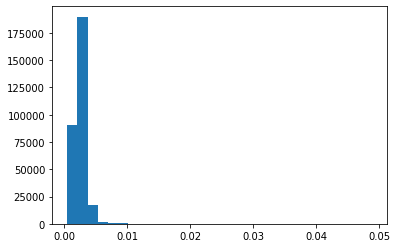

In [ ]:
######### Saved model değil ###############
testX = np.asarray(testX).astype('float32')
testY = np.asarray(testY).astype('float32')

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)




(array([2.72011e+05, 2.52310e+04, 1.79900e+03, 5.50000e+02, 1.68000e+02,
        4.10000e+01, 1.80000e+01, 1.20000e+01, 9.00000e+00, 1.30000e+01,
        1.30000e+01, 1.20000e+01, 5.00000e+00, 5.00000e+00, 6.00000e+00,
        7.00000e+00, 7.00000e+00, 1.10000e+01, 2.00000e+00, 3.00000e+00,
        2.00000e+00, 1.00000e+00, 3.00000e+00, 3.00000e+00, 3.00000e+00,
        1.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([0.00024943, 0.00182591, 0.0034024 , 0.00497889, 0.00655538,
        0.00813186, 0.00970835, 0.01128484, 0.01286133, 0.01443782,
        0.0160143 , 0.01759079, 0.01916728, 0.02074377, 0.02232025,
        0.02389674, 0.02547323, 0.02704972, 0.02862621, 0.03020269,
        0.03177918, 0.03335567, 0.03493216, 0.03650865, 0.03808513,
        0.03966162, 0.04123811, 0.04281459, 0.04439108, 0.04596757,
        0.04754406], dtype=float32),
 <a list of 30 Patch objects>)

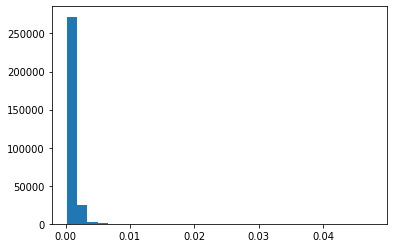

In [ ]:
#############Saved model ile test ediyoruz ##########
testX = np.asarray(testX).astype('float32')
testY = np.asarray(testY).astype('float32')

testPredict = lstmAutoEncoder.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)



In [ ]:
#Capture all details in a DataFrame for easy plotting
max_trainMAE = 0.015
anomaly_df = pd.DataFrame(TestSet[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['MeanVoltage'] = TestSet[seq_size:]['MeanVoltage']

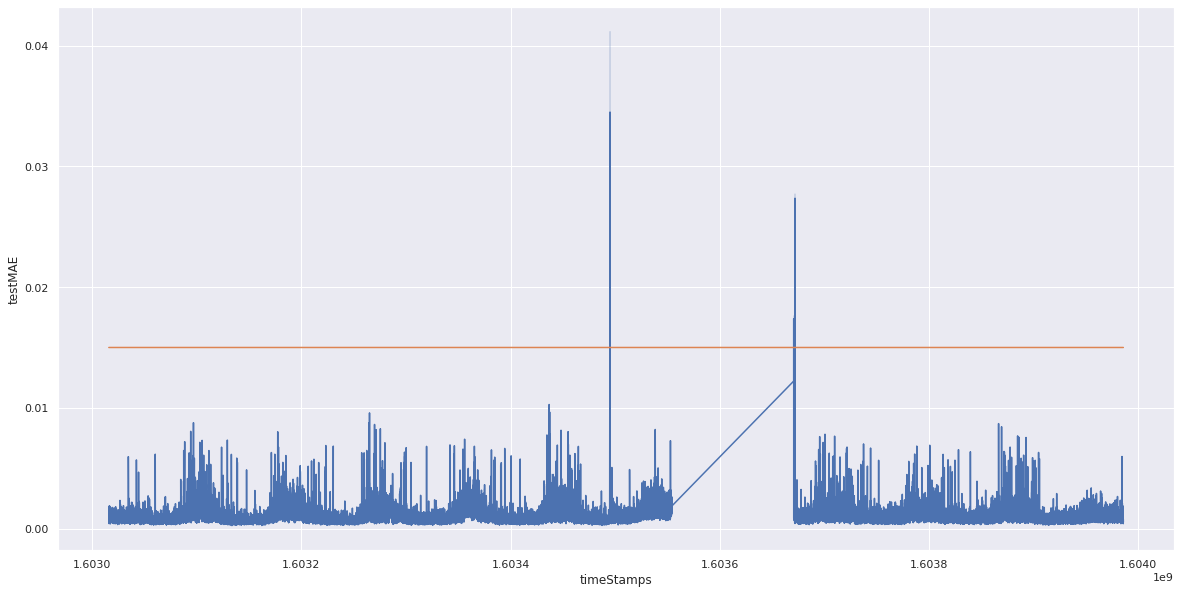

In [ ]:

#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['timeStamps'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['timeStamps'], y=anomaly_df['max_trainMAE'])
sns.set(rc={'figure.figsize':(50,30)})


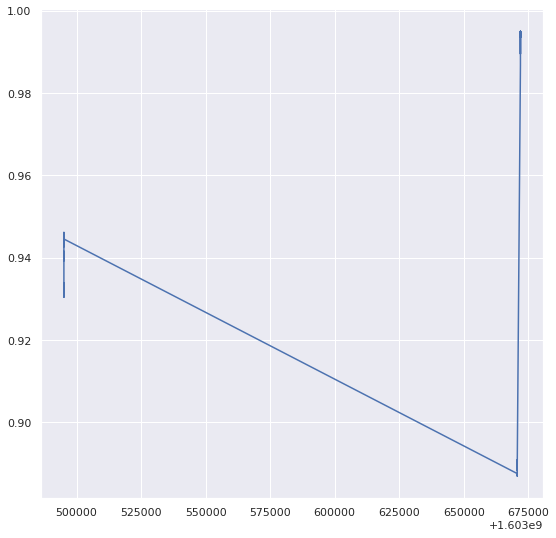

In [ ]:
controlAnomalyTimestamp = np.array(anomalies['timeStamps'])
controlAnomalyMeanvoltage = np.array(anomalies['MeanVoltage'])
plt.figure(figsize=(9, 9))
plt.plot(controlAnomalyTimestamp,controlAnomalyMeanvoltage)


In [ ]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]


In [ ]:
print(anomaly_df.head)
print(anomalies.head)

<bound method NDFrame.head of          timeStamps MeanVoltage   testMAE  max_trainMAE  anomaly
500060  1.60302e+09      232.68  0.000539         0.015    False
500061  1.60302e+09     232.861  0.000582         0.015    False
500062  1.60302e+09     232.801  0.000565         0.015    False
500063  1.60302e+09     232.812  0.000513         0.015    False
500064  1.60302e+09     232.849  0.000480         0.015    False
...             ...         ...       ...           ...      ...
799996  1.60399e+09     232.345  0.000669         0.015    False
799997  1.60399e+09     232.237  0.000560         0.015    False
799998  1.60399e+09     232.333  0.000519         0.015    False
799999  1.60399e+09     232.081  0.000504         0.015    False
800000  1.60399e+09     232.429  0.000537         0.015    False

[299941 rows x 5 columns]>
<bound method NDFrame.head of          timeStamps MeanVoltage   testMAE  max_trainMAE  anomaly
659234   1.6035e+09     223.726  0.022963         0.015     True
65

In [ ]:
print(anomaly_df.shape)
print(anomalies.shape)


(299941, 5)
(99, 5)


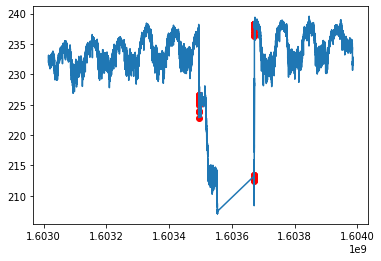

In [ ]:
plt.plot(anomaly_df['timeStamps'],anomaly_df['MeanVoltage'])
plt.scatter(anomalies['timeStamps'],anomalies['MeanVoltage'],color='red')
plt.show()
#Plot anomalies
#sns.lineplot(x=anomaly_df['timeStamps'], y=StandardScaler.fit_transform(anomaly_df['MeanVoltage']))
#sns.scatterplot(x=anomalies['timeStamps'], y=StandardScaler.fit_transform(anomalies['MeanVoltage']), color='r')